## Implémentation d’un générateur de lois alpha-stables

### Objectif
Cette première étape consiste à implémenter un générateur permettant de simuler des variables aléatoires suivant une distribution alpha-stable 
𝑆
(
𝛼
,
𝛽
,
𝜎
,
𝜇
)
S(α,β,σ,μ), conformément à la description de l'Appendix B de l’article Sisson (2011). L'algorithme retenu est celui de Chambers, Mallows et Stuck (1976), qui repose sur la transformation de deux lois élémentaires.

### Générateur CMS : implémentation Python


In [5]:
import numpy as np

def sample_alpha_stable(alpha, beta, sigma=1, mu=0, size=1):
    U = np.pi * (np.random.rand(size) - 0.5)  # Uniforme sur (-π/2, π/2)
    W = np.random.exponential(scale=1.0, size=size)  # Exp(1)

    if alpha != 1:
        numerator = np.sin(alpha * U)
        denominator = (np.cos(U))**(1 / alpha)
        inner = np.cos((1 - alpha) * U) / W
        X = numerator / denominator * (inner) ** ((1 - alpha) / alpha)
    else:
        B = (2 / np.pi) * ((np.pi / 2) + beta * U) * np.tan(U) - \
            beta * np.log((np.pi / 2 * W * np.cos(U)) / ((np.pi / 2) + beta * U))
        X = B

    return sigma * X + mu



### Validation empirique : visualisation de quelques lois

Nous testons le générateur pour différentes valeurs de \(\alpha\) et \(\beta\), en représentant les histogrammes des échantillons simulés.



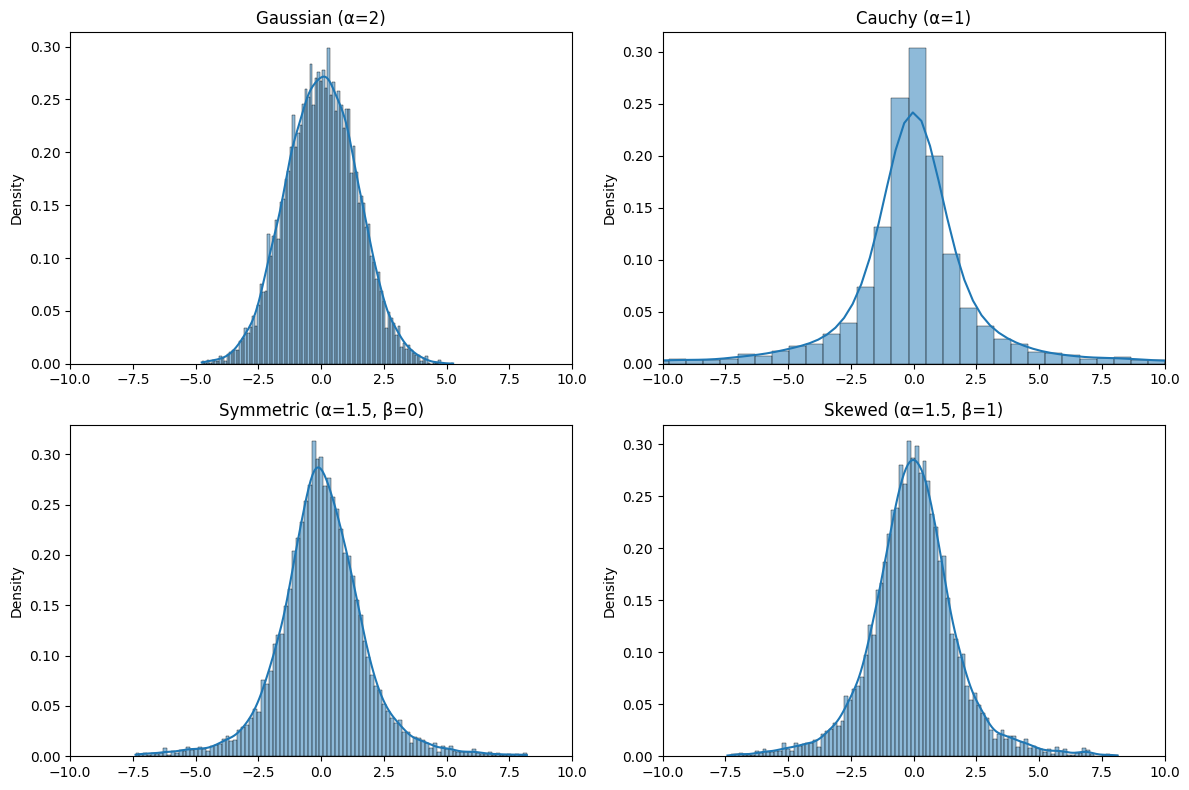

In [10]:


# Paramètres à tester
params = [
    (2.0, 0, 1, 0, 'Gaussian (α=2)'),
    (1.0, 0, 1, 0, 'Cauchy (α=1)'),
    (1.5, 0, 1, 0, 'Symmetric (α=1.5, β=0)'),
    (1.5, 1, 1, 0, 'Skewed (α=1.5, β=1)'),
]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for i, (alpha, beta, sigma, mu, title) in enumerate(params):
    data = sample_alpha_stable(alpha, beta, sigma, mu, size=10000)
    
    # On élimine les valeurs extrêmes (1% aux deux extrémités) pour les cas Cauchy et Skewed
    if alpha <= 1.5:
        lower, upper = np.percentile(data, 1), np.percentile(data, 99)
        data = data[(data >= lower) & (data <= upper)]
    
    sns.histplot(data, kde=True, stat='density', ax=axs[i], bins=100)
    axs[i].set_title(title)
    axs[i].set_xlim(-10, 10)
    axs[i].set_xlabel("")
    axs[i].set_ylabel("Density")

plt.tight_layout()
plt.show()


### Validation via la fonction caractéristique

Une seconde manière de tester la validité du générateur consiste à comparer la **fonction caractéristique empirique** 


La densité des lois alpha-stables n'étant généralement pas disponible en forme fermée (sauf cas particuliers), on ne peut pas la comparer directement à une estimation empirique. En revanche, leur **fonction caractéristique** (FC) est connue explicitement et constitue un outil efficace pour valider numériquement un générateur de variables alpha-stables.

#### Définition

La fonction caractéristique d’une variable aléatoire \( X \) est définie par :

$$
\varphi_X(t) = \mathbb{E}[e^{itX}]
$$

Pour \( X \sim \mathcal{S}(\alpha, \beta, \gamma, \delta) \), la fonction caractéristique théorique est :

- Si \( \alpha =/ 1 \) :

$$
\varphi_X(t) = \exp\left( -\gamma^\alpha |t|^\alpha \left[ 1 - i\beta\, \text{sign}(t) \tan\left( \frac{\pi \alpha}{2} \right) \right] + i \delta t \right)
$$

- Si \( \alpha = 1 \) :

$$
\varphi_X(t) = \exp\left( -\gamma |t| \left[ 1 + i\beta \frac{2}{\pi} \, \text{sign}(t) \log|t| \right] + i \delta t \right)
$$

#### Méthode

On génère un grand nombre d’observations \( X_1, \dots, X_N \) avec le générateur, puis on calcule l’estimateur empirique :

$$
\hat{\varphi}_X(t) = \frac{1}{N} \sum_{j=1}^{N} e^{itX_j}
$$

On compare ensuite les resultats obtenus via les courbes :


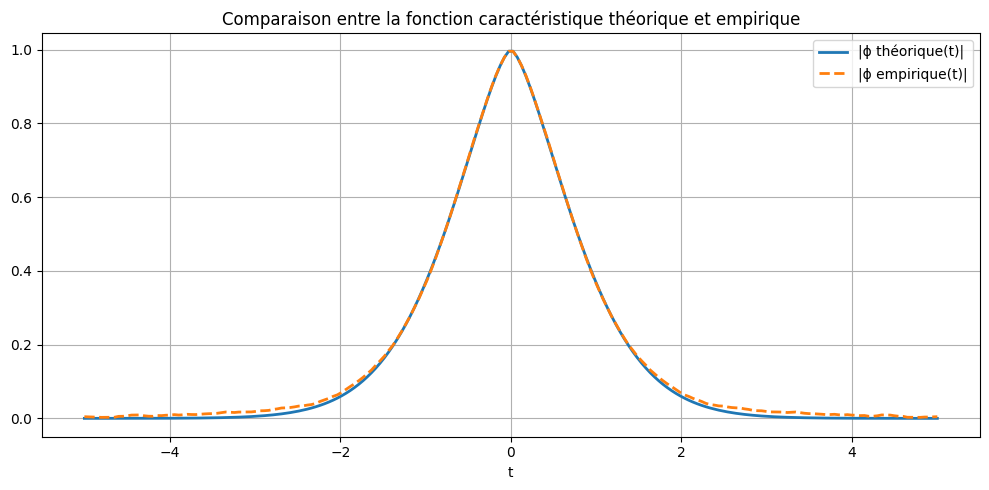

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Fonction caractéristique théorique
def theoretical_cf(t, alpha, beta, gamma=1, delta=0):
    if alpha != 1:
        return np.exp(
            -gamma**alpha * np.abs(t)**alpha *
            (1 - 1j * beta * np.sign(t) * np.tan(np.pi * alpha / 2)) +
            1j * delta * t
        )
    else:
        return np.exp(
            -gamma * np.abs(t) *
            (1 + 1j * beta * (2 / np.pi) * np.sign(t) * np.log(np.abs(t))) +
            1j * delta * t
        )

# Estimateur empirique de la fonction caractéristique
def empirical_cf(t_vals, samples):
    return np.array([np.mean(np.exp(1j * t * samples)) for t in t_vals])

# Paramètres de test
alpha = 1.5
beta = 0
gamma = 1
delta = 0
N = 10_000

# Génération d'échantillons
samples = sample_alpha_stable(alpha, beta, sigma, mu, size=N)

# Grille de t
t_vals = np.linspace(-5, 5, 200)

# Fonction caractéristique théorique et empirique
phi_theo = theoretical_cf(t_vals, alpha, beta, gamma, delta)
phi_emp = empirical_cf(t_vals, samples)

# Tracé des modules
plt.figure(figsize=(10, 5))
plt.plot(t_vals, np.abs(phi_theo), label="|ϕ théorique(t)|", lw=2)
plt.plot(t_vals, np.abs(phi_emp), label="|ϕ empirique(t)|", lw=2, linestyle="--")
plt.xlabel("t")
plt.title("Comparaison entre la fonction caractéristique théorique et empirique")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
